In [3]:
%matplotlib inline

import os

import random
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

2024-12-24 22:25:11.572606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-24 22:25:12.180634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
#Checking if there is any available GPU
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


2024-12-24 22:25:14.253758: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-24 22:25:14.272586: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-24 22:25:14.272651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.


### Images Dataset

The dataset used in this notebook is the "Images Dataset" from Kaggle, which can be downloaded at https://www.kaggle.com/datasets/pavansanagapati/images-dataset.
This dataset comprises seven classes: bike, cars, cats, dogs, flowers, horses, and human.

In [5]:
root = './data'


categories = []
for roots, dirs, files in os.walk(root):
    categories = dirs
    print(categories)
    break



['bike', 'cars', 'cats', 'dogs', 'flowers', 'horses', 'human']


### Load the dataset
Let's use  [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) for loading images from a directory.

In [6]:
batch_size = 8 # number of images processed in parallel
img_height = 480
img_width = 640

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    
    './data',
    validation_split=0.20,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
    
)

    

Found 1804 files belonging to 7 classes.
Using 1444 files for training.


2024-12-24 22:25:25.078084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-24 22:25:25.078187: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-24 22:25:25.078234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-24 22:25:25.263422: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-24 22:25:25.263486: I external/local_xla/xla/stream_executor

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    
    './data',
    validation_split=0.20,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

Found 1804 files belonging to 7 classes.
Using 360 files for validation.


### Visualize the data

In [10]:
class_names = train_ds.class_names
print(class_names)

['bike', 'cars', 'cats', 'dogs', 'flowers', 'horses', 'human']


2024-12-24 22:26:38.068804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


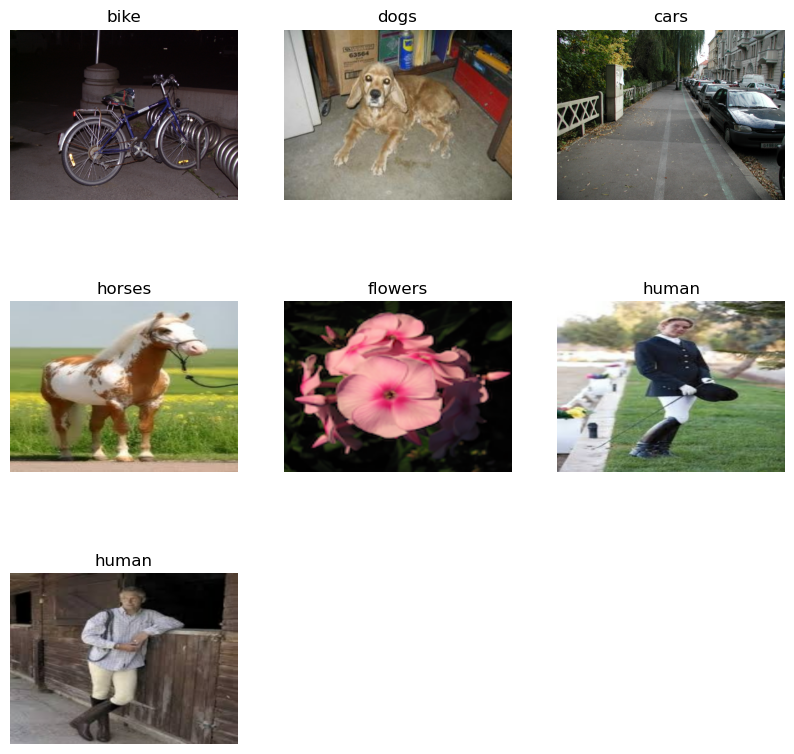

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(7):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Images batches dimensions

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch)  
  break
# For the defined batch, there are eight images per batch with a height of 480, a width of 640, and 3 channels(RGB).
# and 8 labels, one for each image in the batch

(8, 480, 640, 3)
tf.Tensor([3 5 5 1 2 0 0 0], shape=(8,), dtype=int32)


### Enhance dataset performance
we can use [Dataset.cache](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [Dataset.prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) to preprocess the data while training and caching the preprocessing results.

In [14]:
#Automatically define the best parameter
AUTOTUNE = tf.data.AUTOTUNE

#Do not provide filename to save cache in memory - make sure data will fit in memory
train_ds = train_ds\
            .cache(filename='train_cache')\
            .prefetch(buffer_size=AUTOTUNE)


val_ds = val_ds\
            .cache(filename='val_cache')\
            .prefetch(buffer_size=AUTOTUNE)




### Training from scratch
We will build first a model from scratch to have a baseline for transfer learning.

In [15]:
num_classes = 7

def create_model ():
    model = tf.keras.Sequential([
      tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.build(input_shape=(None, img_height, img_width, 3))
    model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#from_logits=False because we are already using softmax the at output layer

    metrics=['accuracy'])
    
    return model

In [16]:
model = create_model()
model.summary()




checkpoint_filepath = './checkpoint.scratch_model.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True,
    save_best_only=True
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 480, 640, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 478, 638, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 239, 319, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 237, 317, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 118, 158, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 116, 156, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 58, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 144768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,530,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,550,727 (70.77 MB)

 Trainable params: 18,550,727 (70.77 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3, #if val_loss do not decrease with 3 epochs, stop training    
)

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  callbacks=[early_stop, model_checkpoint_callback]  
)

Epoch 1/30


I0000 00:00:1735079270.787362    2520 service.cc:145] XLA service 0x7f9630002140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735079270.787450    2520 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-12-24 22:27:50.807994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-24 22:27:50.900434: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-24 22:28:40.000698: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=0,k13=2,k14=3,k18=0,k23=0} for conv (f32[8,32,239,319]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,237,317]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wa

  3/181 ━━━━━━━━━━━━━━━━━━━━ 1:08:40 23s/step - accuracy: 0.2222 - loss: 3.8425

I0000 00:00:1735079278.675433    2520 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/181 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - accuracy: 0.3327 - loss: 2.1551

2024-12-24 22:29:00.036846: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,239,319]{3,2,1,0}, f32[4,32,237,317]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-24 22:29:00.067256: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 46.272826713s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,239,319]{3,2,1,0}, f32[4,32,237,317]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_re

181/181 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - accuracy: 0.3519 - loss: 2.0590 - val_accuracy: 0.4667 - val_loss: 1.5186
Epoch 2/30
152/181 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6473 - loss: 1.0959

2024-12-24 22:28:32.618331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-24 22:28:32.618372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-24 22:28:32.618384: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2800479981480644694
2024-12-24 22:28:32.618402: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4359255246017853308


181/181 ━━━━━━━━━━━━━━━━━━━━ 15s -176785us/step - accuracy: 0.6482 - loss: 1.0832 - val_accuracy: 0.6333 - val_loss: 1.0454
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.7715 - loss: 0.7409 - val_accuracy: 0.6056 - val_loss: 1.2166
Epoch 4/30


2024-12-24 22:28:50.795923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-24 22:28:50.795971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-24 22:28:50.795984: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2800479981480644694
2024-12-24 22:28:50.796006: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4359255246017853308


181/181 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.8484 - loss: 0.4680 - val_accuracy: 0.6333 - val_loss: 1.5002
Epoch 5/30


2024-12-24 22:29:17.275081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-24 22:29:17.275128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-24 22:29:17.275141: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2800479981480644694
2024-12-24 22:29:17.275163: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4359255246017853308


181/181 ━━━━━━━━━━━━━━━━━━━━ 43s 236ms/step - accuracy: 0.9406 - loss: 0.1796 - val_accuracy: 0.6222 - val_loss: 1.6898


2024-12-24 22:30:00.074146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-24 22:30:00.074199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-24 22:30:00.074214: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2800479981480644694
2024-12-24 22:30:00.074237: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4359255246017853308


### Using a existing model(VGG16) to apply transfer learning to our dataset

In [19]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 49s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = tf.keras.Model(inp, out)


In [28]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,289,223 (512.27 MB)

 Trainable params: 28,679 (112.03 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [34]:
# def preprocess_image(image, label):
#     # Resize to (224, 224)
#     image = tf.image.resize(image, (224, 224))
#     return image, label

# train_ds = train_ds.map(preprocess_image)
# val_ds = val_ds.map(preprocess_image)

train_ds = tf.keras.utils.image_dataset_from_directory(
    
    './data',
    validation_split=0.20,
    subset="training",
    seed=123,
    image_size=(224, 224),#VGG16 image size
    batch_size=batch_size,
    shuffle=True
    
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    
    './data',
    validation_split=0.20,
    subset="validation",
    seed=123,
    image_size=(224, 224),#VGG16 image size
    batch_size=batch_size,
    shuffle=True
)

# train_ds = train_ds\
#             .cache(filename='train_cache')\
#             .prefetch(buffer_size=AUTOTUNE)


# val_ds = val_ds\
#             .cache(filename='val_cache')\
#             .prefetch(buffer_size=AUTOTUNE)


Found 1804 files belonging to 7 classes.
Using 1444 files for training.
Found 1804 files belonging to 7 classes.
Using 360 files for validation.


In [35]:
history2 = model_new.fit(train_ds,
                         validation_data=val_ds,
                         batch_size=8, 
                         epochs=30, 
                         callbacks=[early_stop]
                        )


Epoch 1/30


I0000 00:00:1735080809.259490    7577 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_743', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1735080809.374893    7583 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_750', 468 bytes spill stores, 352 bytes spill loads

I0000 00:00:1735080809.520145    7575 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_743', 68 bytes spill stores, 68 bytes spill loads

2024-12-24 22:54:17.449699: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng35{k2=2,k3=0} for conv (f32[8,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operati

149/181 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.8399 - loss: 0.6205

I0000 00:00:1735080823.320454    7677 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_743', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1735080823.774919    7678 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_743', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1735080823.884721    7677 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_750', 468 bytes spill stores, 352 bytes spill loads

2024-12-24 22:54:31.760957: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[4,256,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,256,56,56]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wai

181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.8547 - loss: 0.5604 - val_accuracy: 0.9278 - val_loss: 0.2956
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9800 - loss: 0.0675 - val_accuracy: 0.9583 - val_loss: 0.1713
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9907 - loss: 0.0187 - val_accuracy: 0.9556 - val_loss: 0.1342
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9979 - loss: 0.0060 - val_accuracy: 0.9583 - val_loss: 0.1401
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 1.0000 - loss: 3.8434e-04 - val_accuracy: 0.9556 - val_loss: 0.1450
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 1.0000 - loss: 2.9952e-04 - val_accuracy: 0.9611 - val_loss: 0.1377


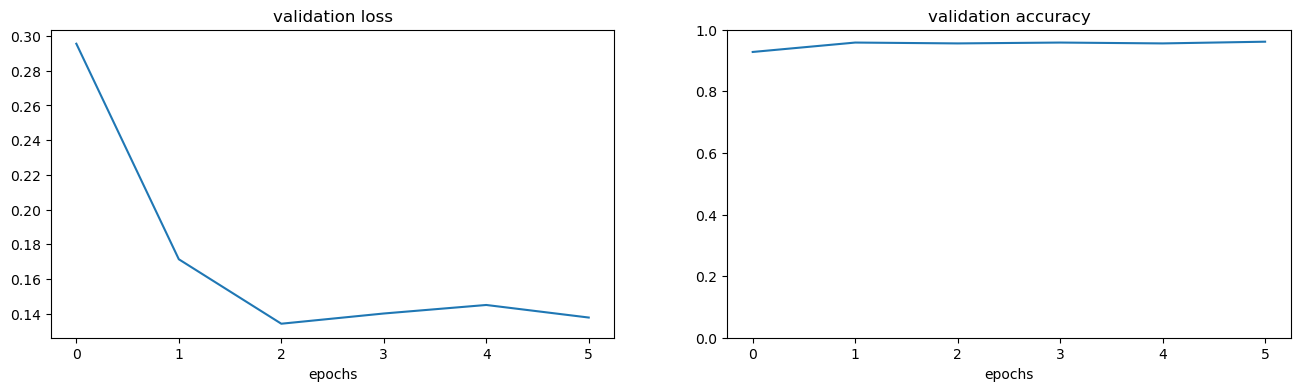

In [38]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

### Conclusion

The results show that using transfer learning and only training the final classification layer is much more effective than training a model from scratch.
While transfer learning achieves 96% validation accuracy, the model built from scratch achieves less than 70%.
